## Library

In [ ]:
!pip install transformers
!pip install sentence_transformers
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 118.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 90.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.0 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=b667cf78418866a0559089c1b90e3621e7c86043a3b1017d702b0579e34a4f14
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 5.3 MB

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
%cd /content/drive/MyDrive/classification

In [ ]:
from transformers import AutoModelForSequenceClassification,Trainer,AutoTokenizer,TrainingArguments
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,f1_score,precision_score
from sklearn.model_selection import train_test_split

## Data pre-processing

In [ ]:
#Importing into the database, 'dataset = 1' represents the tweet dataset, 2 stands for the Kaggle dataset, and 3 for the liar dataset

dataset = "3"

if dataset == "1":

    df = pd.read_excel("Constraint_Train.xlsx")
    test_df  = pd.read_excel("Constraint_Test.xlsx")

elif dataset == "2":

    #df = pd.read_excel("texts_labeled_cleaned.xlsx")
    df = pd.read_excel("./BERT/BERT/2/texts_labeled_cleaned.xlsx")

    df.columns = ["tweet","label"]


    df,test_df = train_test_split(df,test_size=0.1,random_state=12)

elif dataset == "3":

    train = pd.read_csv('./BERT/BERT/3/train.csv',delimiter='\t')
    test = pd.read_csv('./BERT/BERT/3/test.csv',delimiter='\t')
    valid = pd.read_csv('./BERT/BERT/3/valid.csv',delimiter='\t')
    #train = pd.read_csv('train.csv',delimiter='\t')
    #test = pd.read_csv('test.csv',delimiter='\t')
    #valid = pd.read_csv('valid.csv',delimiter='\t')

    replace_dict = {'half-true': 0, 'mostly-true': 0, 'false': 0, 'true': 1, 'barely-true': 0, 'pants-fire': 0}

    train['false'] = train['false'].replace(replace_dict)

    test['true'] = test['true'].replace(replace_dict)

    valid['barely-true'] = valid['barely-true'].replace(replace_dict)

    value_counts = train['false'].value_counts()

    label_train = train['false'].tolist()
    label_test = test['true'].tolist()
    train_set = train['Says the Annies List political group supports third-trimester abortions on demand.'].tolist()
    test_set = test['Building a wall on the U.S.-Mexico border will take literally years.'].tolist()
    unlabeled = valid['We have less Americans working now than in the 70s.'].tolist()
    df = pd.DataFrame({"tweet" : train_set + test_set,
              "label" : label_train + label_test })

    test_df = pd.DataFrame({"tweet" : unlabeled} )


class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
encoder = LabelEncoder()
df['label'] = encoder.fit_transform( df['label'] )

In [ ]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return {"accuracy" : accuracy_score(labels,predictions),
            "f1"  : f1_score(labels,predictions),
            "precision"  : precision_score(labels,predictions)}

## BERT classifier

In [ ]:
model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

id2label = {0 : 0 ,1 : 1}
label2id = {0 : 0, 1 : 1}

model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2, id2label=id2label, label2id=label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_df,val_df = train_test_split(df,test_size=0.2,random_state=12)

In [ ]:
train_encoding =  tokenizer(train_df['tweet'].values.tolist(), truncation=True, padding=True)
val_encoding   = tokenizer(val_df['tweet'].values.tolist(), truncation=True, padding=True)
train_dataset = TextDataset(train_encoding,train_df['label'].values.tolist())
val_dataset   = TextDataset(val_encoding,val_df['label'].values.tolist())

In [ ]:
training_args = TrainingArguments(
    output_dir=model_name,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision
1,0.448200,0.428608,0.841373,0.000000,0.000000
2,0.394600,0.433996,0.826597,0.167015,0.350877


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=1152, training_loss=0.4161780642138587, metrics={'train_runtime': 447.8688, 'train_samples_per_second': 41.101, 'train_steps_per_second': 2.572, 'total_flos': 4843348307066880.0, 'train_loss': 0.4161780642138587, 'epoch': 2.0})

## Cross dataset testing

In [ ]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
        # self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        keys = self.encodings.keys()
        keys = list(keys)

        return len(self.encodings[keys[0]])

In [ ]:
df = pd.read_excel("./BERT/BERT/1/Constraint_Train.xlsx")
encoding =  tokenizer(df['tweet'].values.tolist(), truncation=True, padding=True)
labels  =  LabelEncoder().fit_transform( df["label"].values )

test_dataset=TestDataset(encoding)
trainer.model.eval()
test_predict = trainer.predict(test_dataset)
# trainer.predict(test_dataset)

In [ ]:
np.mean(test_predict.predictions.argmax(axis = 1) == labels)

0.4766355140186916

## Embedding

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer(model_name)

In [ ]:
train_embedding = model.encode(train_df["tweet"].values.tolist())
val_embedding   = model.encode(val_df["tweet"].values.tolist())

In [ ]:
train_embedding.shape

(9204, 768)

In [ ]:
val_embedding.shape

(2301, 768)

In [ ]:
train_label = train_df["label"].tolist()
val_label   = val_df["label"].tolist()

## classical classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score

In [ ]:
def compute_metrics(model_name,predict,true):
    return {
        "model_name" : model_name,
        "accuracy" : accuracy_score(true,predict),
        "f1" : f1_score(true,predict),
        "precision" : precision_score(true,predict)
    }

In [ ]:
models = [KNeighborsClassifier,LogisticRegression,DecisionTreeClassifier,MLPClassifier]
result = []
for m in models:
    model = m()
    model.fit(train_embedding,
              train_label)

    val_predict = model.predict(val_embedding)

    result.append(compute_metrics(m.__name__,
                                  val_predict,
                                  val_label))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print("dataset:",dataset)

pd.DataFrame(result)

dataset: 3


,model_name,accuracy,f1,precision
0,KNeighborsClassifier,0.827032,0.095455,0.280000
1,LogisticRegression,0.826597,0.082759,0.257143
2,DecisionTreeClassifier,0.709691,0.169154,0.154897
3,MLPClassifier,0.797045,0.204429,0.270270


## KNN method

In [ ]:
from tqdm.auto import tqdm

Ks = [1,2,3,4,5,6,7,8,9,10,20,30]

result = []

for k in tqdm(Ks):
    model = KNeighborsClassifier(n_neighbors=k)

    model.fit(train_embedding,train_label)

    val_predict = model.predict(val_embedding)

    result.append(compute_metrics("{}".format(k),
                                  val_predict,
                                  val_label))


  0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
knndf = pd.DataFrame(result)

knndf.columns = ["K","accuracy","f1","precision"]
knndf.index = knndf.K

knndf = knndf.drop(columns = ["K"])
knndf

,accuracy,f1,precision
K,,,
1,0.764450,0.230114,0.238938
2,0.837462,0.117925,0.423729
3,0.808779,0.169811,0.272727
4,0.836158,0.059850,0.333333
5,0.827032,0.095455,0.280000
6,0.837027,0.020888,0.222222
7,0.833551,0.035264,0.218750
8,0.839635,0.010724,0.250000
9,0.838766,0.036364,0.350000


<Axes: xlabel='K'>

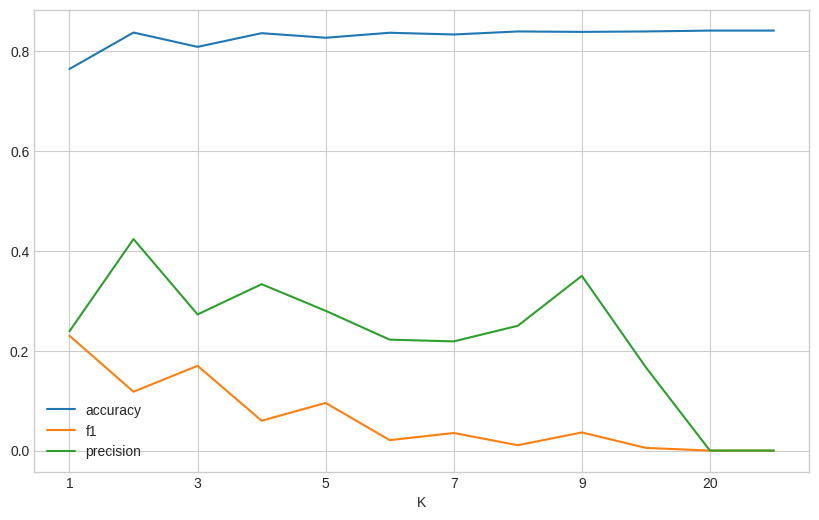

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")

fig,ax = plt.subplots(1,1,figsize=(10,6))
knndf.plot(ax = ax)

## MLP realization

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import numpy as np
import random
import torch.optim as optim

In [ ]:
X_train = torch.tensor(train_embedding, dtype=torch.float32)
y_train = torch.tensor(train_label, dtype=torch.long)
X_val = torch.tensor(val_embedding, dtype=torch.float32)
y_val = torch.tensor(val_label, dtype=torch.long)

In [ ]:
# Create datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Define data loaders
batch_size = 32  # You can change the batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class BinaryMLPClassifier(nn.Module):
    def __init__(self, input_dim=768, hidden_layer_sizes=[512, 256], dropout_rate=0.5):
        super(BinaryMLPClassifier, self).__init__()

        # Initialize layers
        self.layers = nn.Sequential()

        # Input layer
        current_input_dim = input_dim

        # Add hidden layers
        for i, hidden_size in enumerate(hidden_layer_sizes):
            self.layers.add_module('linear{}'.format(i), nn.Linear(current_input_dim, hidden_size))
            self.layers.add_module('relu{}'.format(i), nn.ReLU())
            self.layers.add_module('dropout{}'.format(i), nn.Dropout(dropout_rate))
            current_input_dim = hidden_size  # Update input dim for the next layer

        # Output layer
        self.layers.add_module('output', nn.Linear(current_input_dim, 1))


    def forward(self, x):
        return self.layers(x)  # No sigmoid, assuming BCEWithLogitsLoss will be used

In [ ]:
# Set random seed for reproducibility
def set_seed(seed_value):
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    np.random.seed(seed_value)

    random.seed(seed_value)

# Random seed set to some fixed number
set_seed(42)

# Initialize your model, optimizer, and loss function
model = BinaryMLPClassifier()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.005, weight_decay=1e-4)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()

# Track the best accuracy
best_accuracy = 0.0
best_epoch = 0

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze(1)
        labels = labels.float()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            predictions = torch.round(torch.sigmoid(outputs))
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_targets, all_predictions)
    print(f'Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {accuracy:.4f}')

    # Save the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'New best model saved at epoch {epoch + 1} with accuracy {best_accuracy:.4f}')

print(f'Best Accuracy: {best_accuracy:.4f} at epoch {best_epoch + 1}')